Loaded PubMed dataset with 19717 nodes, 88648 edges.
Training GCN on PubMed...
Epoch 50/200, Loss: 0.9367
Epoch 100/200, Loss: 0.6909
Epoch 150/200, Loss: 0.4743
Epoch 200/200, Loss: 0.3567
Test Accuracy: 0.7820
Posterior Attack AUC: 0.9472
Combined Attack AUC: 0.8368
Training GraphSAGE on PubMed...
Epoch 50/200, Loss: 0.9350
Epoch 100/200, Loss: 0.6865
Epoch 150/200, Loss: 0.4821
Epoch 200/200, Loss: 0.3465
Test Accuracy: 0.7810
Posterior Attack AUC: 0.9616
Combined Attack AUC: 0.8512
Training GAT on PubMed...
Epoch 50/200, Loss: 0.9360
Epoch 100/200, Loss: 0.6749
Epoch 150/200, Loss: 0.4671
Epoch 200/200, Loss: 0.3496
Test Accuracy: 0.7810
Posterior Attack AUC: 0.9632
Combined Attack AUC: 0.8544
Training GIN on PubMed...
Epoch 50/200, Loss: 0.9429
Epoch 100/200, Loss: 0.6848
Epoch 150/200, Loss: 0.4827
Epoch 200/200, Loss: 0.3613
Test Accuracy: 0.7780
Posterior Attack AUC: 0.9344
Combined Attack AUC: 0.8768

Final Results:
  Dataset      Model  Accuracy     AUC
0  PubMed        GCN  

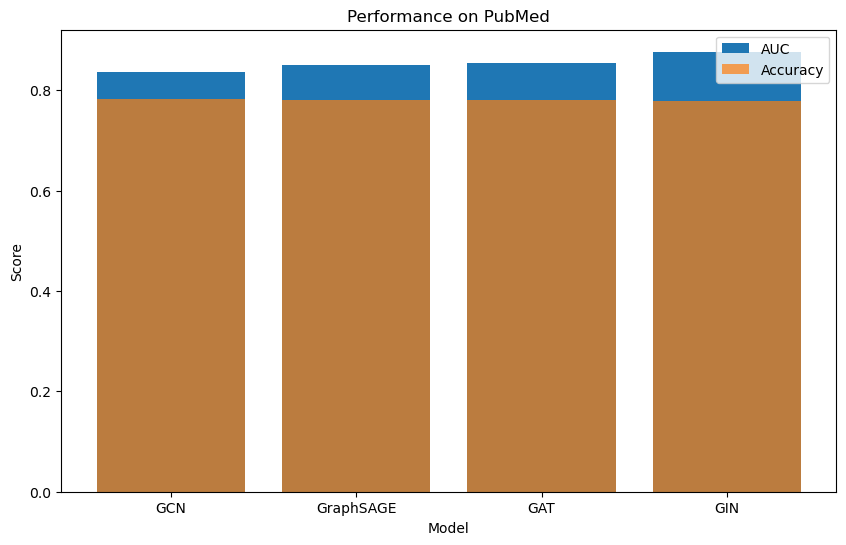

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch.optim as optim
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.transforms import NormalizeFeatures

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# --- Dataset Loading ---
def load_dataset(name):
    """Load and preprocess the dataset."""
    dataset = Planetoid(root=f'./data/{name}', name=name, transform=NormalizeFeatures())
    data = dataset[0]
    print(f"Loaded {name} dataset with {data.num_nodes} nodes, {data.num_edges} edges.")
    return dataset, data

# Step 2: Define GNN Model
class GNN(torch.nn.Module):
    def __init__(self, model_type, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.dropout = Dropout(p=dropout)
        if model_type == 'GCN':
            self.layers = ModuleList([
                GCNConv(in_channels, hidden_channels),
                GCNConv(hidden_channels, out_channels)
            ])
        elif model_type == 'GraphSAGE':
            self.layers = ModuleList([
                SAGEConv(in_channels, hidden_channels),
                SAGEConv(hidden_channels, out_channels)
            ])
        elif model_type == 'GAT':
            self.layers = ModuleList([
                GATConv(in_channels, hidden_channels, heads=2),
                GATConv(2 * hidden_channels, out_channels, heads=1)
            ])
        elif model_type == 'GIN':
            self.layers = ModuleList([
                GINConv(Linear(in_channels, hidden_channels)),
                GINConv(Linear(hidden_channels, out_channels))
            ])
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

    def forward(self, x, edge_index):
        for layer in self.layers[:-1]:
            x = self.dropout(layer(x, edge_index).relu())
        return self.layers[-1](x, edge_index)

# --- Training and Testing Functions ---
def train_model(model, data, optimizer, num_epochs=200):
    """Train the model."""
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

def test_model(model, data):
    """Test the model."""
    model.eval()
    with torch.no_grad():
        output = model(data)
        pred = output[data.test_mask].max(1)[1]
        correct = (pred == data.y[data.test_mask]).sum()
        accuracy = correct / data.test_mask.sum()
    return accuracy.item()

# --- Attack Functions ---
def posterior_attack(model, data, node_u, node_v, hops=0):
    """Perform posterior-only attack."""
    model.eval()
    with torch.no_grad():
        embedding_u = model.conv1(data.x, data.edge_index)[node_u]
        embedding_v = model.conv1(data.x, data.edge_index)[node_v]
        if hops >= 1:
            neighbors_u = data.edge_index[1][data.edge_index[0] == node_u]
            neighbors_v = data.edge_index[1][data.edge_index[0] == node_v]
            embedding_u += torch.mean(model.conv1(data.x, data.edge_index)[neighbors_u], dim=0)
            embedding_v += torch.mean(model.conv1(data.x, data.edge_index)[neighbors_v], dim=0)
        if hops == 2:
            two_hop_neighbors_u = data.edge_index[1][torch.isin(data.edge_index[0], neighbors_u)]
            two_hop_neighbors_v = data.edge_index[1][torch.isin(data.edge_index[0], neighbors_v)]
            embedding_u += torch.mean(model.conv1(data.x, data.edge_index)[two_hop_neighbors_u], dim=0)
            embedding_v += torch.mean(model.conv1(data.x, data.edge_index)[two_hop_neighbors_v], dim=0)
        similarity = torch.dot(embedding_u, embedding_v)
    return similarity.item()

def generate_node_pairs(data, num_pairs=50):
    """Generate positive and negative node pairs."""
    edge_index = data.edge_index.cpu().numpy()
    num_nodes = data.num_nodes
    positive_pairs = list(zip(edge_index[0], edge_index[1]))
    positive_pairs = random.sample(positive_pairs, min(len(positive_pairs), num_pairs // 2))

    negative_pairs = []
    existing_pairs = set(positive_pairs)
    while len(negative_pairs) < num_pairs // 2:
        u, v = random.randint(0, num_nodes - 1), random.randint(0, num_nodes - 1)
        if u != v and (u, v) not in existing_pairs and (v, u) not in existing_pairs:
            negative_pairs.append((u, v))

    node_pairs = positive_pairs + negative_pairs
    labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)
    return node_pairs, labels

def combined_attack(model, data, node_u, node_v, use_attributes=True, use_graph_features=True, hops=0):
    """Combined attack using posteriors, node attributes, and graph features."""
    model.eval()
    with torch.no_grad():
        embedding_u = model.conv1(data.x, data.edge_index)[node_u]
        embedding_v = model.conv1(data.x, data.edge_index)[node_v]
        if hops >= 1:
            neighbors_u = data.edge_index[1][data.edge_index[0] == node_u]
            neighbors_v = data.edge_index[1][data.edge_index[0] == node_v]
            embedding_u += torch.mean(model.conv1(data.x, data.edge_index)[neighbors_u], dim=0)
            embedding_v += torch.mean(model.conv1(data.x, data.edge_index)[neighbors_v], dim=0)
        
        attribute_features = torch.zeros(0)
        if use_attributes:
            attribute_features = torch.cat([data.x[node_u], data.x[node_v]], dim=0)

        graph_features = torch.zeros(0)
        if use_graph_features:
            graph_features = torch.tensor([0.0, 0.0])  # Placeholder for graph features

        combined_features = torch.cat([embedding_u, embedding_v, attribute_features, graph_features])
    return combined_features

# --- Evaluation Functions ---
def evaluate_combined_attack(node_pairs, true_labels, model, data, use_attributes=True, use_graph_features=True, hops=0):
    """Evaluate the combined attack using logistic regression."""
    features = [combined_attack(model, data, u, v, use_attributes, use_graph_features, hops).numpy() for u, v in node_pairs]
    clf = LogisticRegression(max_iter=1000).fit(features, true_labels)
    y_pred = clf.predict_proba(features)[:, 1]
    auc = roc_auc_score(true_labels, y_pred)
    return auc

def plot_results(results_df):
    """Plot the results."""
    for dataset in results_df["Dataset"].unique():
        subset = results_df[results_df["Dataset"] == dataset]
        plt.figure(figsize=(10, 6))
        plt.bar(subset["Model"], subset["AUC"], label="AUC")
        plt.bar(subset["Model"], subset["Accuracy"], label="Accuracy", alpha=0.7)
        plt.title(f"Performance on {dataset}")
        plt.xlabel("Model")
        plt.ylabel("Score")
        plt.legend()
        plt.show()

# --- Main Pipeline ---
def main_pipeline(datasets=["PubMed"], model_types=['GCN', 'GraphSAGE', 'GAT', 'GIN'], use_attributes=True, use_graph_features=True, num_epochs=200):
    results = []
    
    for dataset_name in datasets:
        dataset, data = load_dataset(dataset_name)
        
        for model_type in model_types:
            print(f"Training {model_type} on {dataset_name}...")
            model = GCN(dataset.num_node_features, dataset.num_classes)
            optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
            train_model(model, data, optimizer, num_epochs=num_epochs)
            accuracy = test_model(model, data)
            print(f"Test Accuracy: {accuracy:.4f}")
            
            # Generate node pairs for attack
            node_pairs, true_labels = generate_node_pairs(data, num_pairs=50)
            
            # Evaluate posterior-only attack
            posterior_scores = [posterior_attack(model, data, u, v) for u, v in node_pairs]
            auc_posterior = roc_auc_score(true_labels, posterior_scores)
            print(f"Posterior Attack AUC: {auc_posterior:.4f}")
            
            # Evaluate combined attack
            auc_combined = evaluate_combined_attack(node_pairs, true_labels, model, data, use_attributes, use_graph_features)
            print(f"Combined Attack AUC: {auc_combined:.4f}")
            
            # Store results
            results.append({
                "Dataset": dataset_name,
                "Model": model_type,
                "Accuracy": accuracy,
                "AUC": auc_combined
            })

    results_df = pd.DataFrame(results)
    print("\nFinal Results:")
    print(results_df)
    
    # Plot results
    plot_results(results_df)

    return results_df

# Execute Main Pipeline
results_df = main_pipeline(datasets=["PubMed"], model_types=['GCN', 'GraphSAGE', 'GAT', 'GIN'], use_attributes=True, use_graph_features=True)
